In [121]:
#!pip install yfinance pandas numpy requests matplotlib seaborn plotly statsmodels scikit-learn xgboost

C:\Users\ASUS\Projects\Projectpy\notebooks\../utils\data_fetcher.py:82: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Downloaded 1410 Henry Hub price records
Note: Using simplified weather data generation
For production, consider using OpenWeatherMap API or NOAA data
Generating demo storage data...


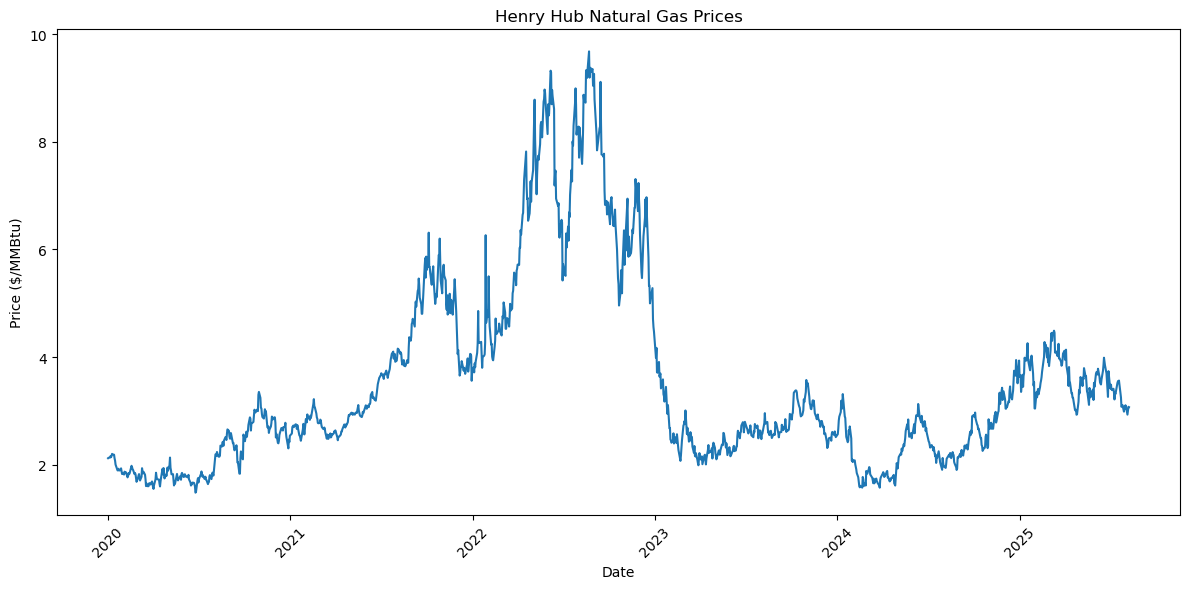

Price data: 1410 records
Date range: 2020-01-02 00:00:00 to 2025-08-07 00:00:00


In [157]:
import sys
sys.path.append('../utils')

from data_fetcher import NaturalGasDataFetcher
import pandas as pd
import matplotlib.pyplot as plt

fetcher = NaturalGasDataFetcher(eia_api_key="oFFfwEonZjh6oENLFfK0XBHeH7nUUcCb0YJh0LJx")

prices = fetcher.get_henry_hub_prices()
weather = fetcher.get_weather_data()

# Use demo storage data
storage = fetcher._generate_demo_data()  # This generates realistic demo data

if prices is not None:
    # Simple analysis with price data
    plt.figure(figsize=(12, 6))
    plt.plot(prices['date'], prices['henry_hub_price'])
    plt.title('Henry Hub Natural Gas Prices')
    plt.xlabel('Date')
    plt.ylabel('Price ($/MMBtu)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"Price data: {prices.shape[0]} records")
    print(f"Date range: {prices['date'].min()} to {prices['date'].max()}")

In [159]:
print("=== HENRY HUB PRICES ===")
if prices is not None:
    print(f"Shape: {prices.shape}")
    print(f"Columns: {list(prices.columns)}")
    print(prices.head())

print("\n=== STORAGE DATA ===")
storage = fetcher.get_storage_data()
if storage is not None:
    print(f"Shape: {storage.shape}")
    print(f"Columns: {list(storage.columns)}")
    print(storage.head())

print("\n=== WEATHER DATA ===") 
if weather is not None:
    print(f"Shape: {weather.shape}")
    print(f"Columns: {list(weather.columns)}")
    print(weather.head())

=== HENRY HUB PRICES ===
Shape: (1410, 2)
Columns: [('date', ''), ('henry_hub_price', 'NG=F')]
Price        date henry_hub_price
Ticker                       NG=F
0      2020-01-02           2.122
1      2020-01-03           2.130
2      2020-01-06           2.135
3      2020-01-07           2.162
4      2020-01-08           2.141

=== STORAGE DATA ===
No data found in API response

=== WEATHER DATA ===
Shape: (1461, 4)
Columns: ['date', 'temperature', 'hdd', 'cdd']
                        date  temperature       hdd       cdd
0 2021-08-09 00:53:09.724070    57.272687  7.727313  0.000000
1 2021-08-10 00:53:09.724070    67.502674  0.000000  2.502674
2 2021-08-11 00:53:09.724070    66.397212  0.000000  1.397212
3 2021-08-12 00:53:09.724070    58.647796  6.352204  0.000000
4 2021-08-13 00:53:09.724070    59.809606  5.190394  0.000000


In [161]:
# If the DataFrame has multi-level columns
if isinstance(prices.columns, pd.MultiIndex):
    prices.columns = ['_'.join(col).strip() if col[1] else col[0] for col in prices.columns.values]

In [163]:
prices = prices.rename(columns={'henry_hub_price_NG=F': 'price'})

In [165]:
prices['date'] = pd.to_datetime(prices['date']).dt.date
weather['date'] = pd.to_datetime(weather['date']).dt.date

In [167]:
start_date = weather['date'].min()
prices = prices[prices['date'] >= start_date]

In [169]:
print(prices.isna().sum())
print(weather.isna().sum())

date     0
price    0
dtype: int64
date           0
temperature    0
hdd            0
cdd            0
dtype: int64


In [171]:
prices['price'] = prices['price'].astype(float)
prices.head()

,date,price
403,2021-08-09,4.060
404,2021-08-10,4.089
405,2021-08-11,4.059
406,2021-08-12,3.933
407,2021-08-13,3.861


In [173]:
weather.head()

,date,temperature,hdd,cdd
0,2021-08-09,57.272687,7.727313,0.000000
1,2021-08-10,67.502674,0.000000,2.502674
2,2021-08-11,66.397212,0.000000,1.397212
3,2021-08-12,58.647796,6.352204,0.000000
4,2021-08-13,59.809606,5.190394,0.000000


In [175]:
full_range = pd.DataFrame({'date': pd.date_range(
    start=min(prices['date'].min(), weather['date'].min()),
    end=max(prices['date'].max(), weather['date'].max()),
    freq='D'
).date})

In [181]:
# Merge the datasets on date
df = full_range.merge(prices, on='date', how='left')
df = df.merge( weather, on='date', how='left')

# Sort by date
df = df.sort_values('date')

# Reset index
df.reset_index(drop=True, inplace=True)

# Final shape and preview
print(df.shape)
print(df.head())

(1461, 5)
         date  price  temperature       hdd       cdd
0  2021-08-09  4.060    57.272687  7.727313  0.000000
1  2021-08-10  4.089    67.502674  0.000000  2.502674
2  2021-08-11  4.059    66.397212  0.000000  1.397212
3  2021-08-12  3.933    58.647796  6.352204  0.000000
4  2021-08-13  3.861    59.809606  5.190394  0.000000


In [183]:
# Fill missing values
df['price'] = df['price'].ffill().bfill()
df['temperature'] = df['temperature'].interpolate()
df['hdd'] = df['hdd'].interpolate()
df['cdd'] = df['cdd'].interpolate()

In [185]:
print(df.head(30))

          date  price  temperature        hdd        cdd
0   2021-08-09  4.060    57.272687   7.727313   0.000000
1   2021-08-10  4.089    67.502674   0.000000   2.502674
2   2021-08-11  4.059    66.397212   0.000000   1.397212
3   2021-08-12  3.933    58.647796   6.352204   0.000000
4   2021-08-13  3.861    59.809606   5.190394   0.000000
5   2021-08-14  3.861    79.858542   0.000000  14.858542
6   2021-08-15  3.861    61.156236   3.843764   0.000000
7   2021-08-16  3.946    71.083654   0.000000   6.083654
8   2021-08-17  3.837    70.611027   0.000000   5.611027
9   2021-08-18  3.852    42.441038  22.558962   0.000000
10  2021-08-19  3.830    59.068835   5.931165   0.000000
11  2021-08-20  3.851    52.170568  12.829432   0.000000
12  2021-08-21  3.851    72.267763   0.000000   7.267763
13  2021-08-22  3.851    78.283214   0.000000  13.283214
14  2021-08-23  3.945    66.059286   0.000000   1.059286
15  2021-08-24  3.896    57.424156   7.575844   0.000000
16  2021-08-25  3.897    55.590

In [187]:
df.to_csv("../data/natural_gas_data.csv", index=False)

In [189]:
from pandas.tseries.offsets import Day

expected_dates = pd.date_range(df['date'].min(), df['date'].max(), freq=Day())
missing_dates = set(expected_dates.date) - set(df['date'])
print("Missing dates:", missing_dates)

Missing dates: set()


In [147]:
df['date'] = pd.to_datetime(df['date'])

# Set 'date' as index for reindexing
df = df.set_index('date')

# Create a complete date range
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex to include missing dates
df = df.reindex(full_range)

# Rename index back to 'date'
df.index.name = 'date'

In [149]:
df = df.ffill()

In [151]:
df['temperature'] = df['temperature'].interpolate()
df['hdd'] = df['hdd'].interpolate()
df['cdd'] = df['cdd'].interpolate()
df['price'] = df['price'].interpolate()

In [153]:
df = df.reset_index()
df.head()

,date,price,temperature,hdd,cdd
0,2021-08-09,4.060,65.903464,0.0,0.903464
1,2021-08-10,4.089,70.456598,0.0,5.456598
2,2021-08-11,4.059,67.208970,0.0,2.208970
3,2021-08-12,3.933,84.662528,0.0,19.662528
4,2021-08-13,3.861,71.412301,0.0,6.412301


In [155]:
expected_dates = pd.date_range(df['date'].min(), df['date'].max(), freq=Day())
missing_dates = set(expected_dates.date) - set(df['date'])
print("Missing dates:", missing_dates)

Missing dates: {datetime.date(2023, 9, 8), datetime.date(2022, 10, 24), datetime.date(2024, 12, 28), datetime.date(2024, 11, 28), datetime.date(2021, 11, 4), datetime.date(2025, 7, 9), datetime.date(2022, 4, 11), datetime.date(2024, 10, 8), datetime.date(2024, 12, 19), datetime.date(2021, 10, 22), datetime.date(2022, 11, 7), datetime.date(2023, 1, 7), datetime.date(2024, 1, 9), datetime.date(2024, 9, 26), datetime.date(2025, 7, 26), datetime.date(2021, 11, 3), datetime.date(2023, 4, 4), datetime.date(2024, 1, 12), datetime.date(2021, 9, 5), datetime.date(2023, 8, 16), datetime.date(2023, 10, 16), datetime.date(2022, 6, 14), datetime.date(2022, 2, 13), datetime.date(2024, 7, 5), datetime.date(2023, 1, 4), datetime.date(2024, 4, 13), datetime.date(2025, 2, 18), datetime.date(2023, 1, 18), datetime.date(2023, 6, 5), datetime.date(2022, 11, 3), datetime.date(2025, 5, 10), datetime.date(2023, 12, 16), datetime.date(2024, 11, 4), datetime.date(2024, 6, 22), datetime.date(2022, 11, 4), dateti